# Path Planning Interview Question

One challenge for our indycar is to generate a trajectory that avoids crashing into competing vehicles. Historically, we've represented this path using cubic splines. 


The path of vehicle is represented using a cubic spline, this is a sequence of polynomial segments which are continuous to the third derivative. 

 <img src="img/cubic_spline.png" width="500"/>


Each $i$th segment of the spline has the equations,

$$x(t) = a_x t^3 + b_x t^2 + c_x t + d_x$$
$$y(t) = a_y t^3 + b_y t^2 + c_y t + d_y$$

for $t \in [0, 1)$.

<img src="img/spline_segment.png" width="500"/>


To simplify things, we're just going to work with one dimension, $x(t)$.

Given $n$ points through which the spline passes, we can interpolate a cubic spline. Note that this each segment of this spline passes through each point and splines segments are constrained to connect and to be continuous to third derivative. 

We can solve the constraints to find the coefficients.

$$ x(t) = a t^3 + b t^2 + c t + d$$
$$ x'(t) = 3 a t^2 + 2 b t + c $$


$$ x(0) = x_0 = d $$
$$ x(1) = x_1 = a + b + c + d $$
$$ x'(0) = x_0' = c $$
$$ x'(1) = 3a + 2b + c $$

We will use cubic polynomials in Hermite form for simplicity. In matrix form, they are:

$$x(t) = \begin{bmatrix} t^3 && t^2 && t & 1 \end{bmatrix} \begin{bmatrix} 2 && -2 && 1 && 1 \\
                -3 && 3 && -2 && -1 \\
                0 && 0 && 1 && 0 \\ 
                1 && 0 && 0 && 0 \end{bmatrix} \begin{bmatrix} \mathbf{p}_0 \\ \mathbf{p}_1 \\ \mathbf{t}_0 \\ \mathbf{t}_1 \end{bmatrix} $$


In [2]:
import numpy as np

def cubic_spline(x, y, tol=1e-100):
    """
    Interpolate using natural cubic splines.
    
    Generates a strictly diagonal dominant matrix then solves.
    
    Returns coefficients:
    b, coefficient of x of degree 1
    c, coefficient of x of degree 2
    d, coefficient of x of degree 3
    """ 
    
    x = np.array(x)
    y = np.array(y)
    
    # check if sorted
    if np.any(np.diff(x) < 0):
        idx = np.argsort(x)
        x = x[idx]
        y = y[idx]
        
    size = len(x)
    delta_x = np.diff(x)
    delta_y = np.diff(y)
    
    # Get A and b
    A = np.zeros(shape = (size,size))
    b = np.zeros(shape=(size,1))
    A[0,0] = 1
    A[-1,-1] = 1
    
    for i in range(1,size-1):
        
        A[i, i-1] = delta_x[i-1]
        A[i, i+1] = delta_x[i]
        A[i,i] = 2*(delta_x[i-1]+delta_x[i])
        
        b[i,0] = 3*(delta_y[i]/delta_x[i] - delta_y[i-1]/delta_x[i-1])
    
    # Solves for c in Ac = b
    c = np.linalg.solve(A, b)
    
    # Solves for d and b
    d = np.zeros(shape = (size-1,1))
    b = np.zeros(shape = (size-1,1))
    for i in range(0,len(d)):
        d[i] = (c[i+1] - c[i]) / (3*delta_x[i])
        b[i] = (delta_y[i]/delta_x[i]) - (delta_x[i]/3)*(2*c[i] + c[i+1])    
    
    return x, y, b.squeeze(), c.squeeze(), d.squeeze()
    
    
def evaluate_spline(x, y, b, c, d, t):
    
    if t < x[0] or t > x[-1]:
        raise Exception("Can't extrapolate")

    # Index of segment to use
    idx = np.argmax(x > t) - 1
            
    dx = t - x[idx]
    value = y[idx] + b[idx]*dx + c[idx]*dx**2 + d[idx]*dx**3
    return value

def sample_spline(x, y, b, c, d, num=500):
    
    interp_y = np.zeros((num,))
    t = np.linspace(x[0], x[-1], num=num, endpoint=False)
    
    for i, t_i in enumerate(t):
        interp_y[i] = evaluate_spline(x, y, b, c, d, t_i)
        
    return t, interp_y
        
    

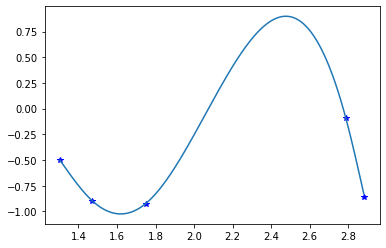

In [4]:
import random
import matplotlib.pyplot as plt

key_points= np.array([[random.random()*3.0,random.random()*2.0-1.0] for i in range(5)])

plt.plot(key_points[:, 0], key_points[:, 1], "*b")

x, y, b, c, d = cubic_spline(key_points[:, 0], key_points[:, 1])

t, interp_y = sample_spline(x, y, b, c, d)


plt.plot(t, interp_y)

